# Notebook do Projeto do Aluno 
## Matéria: Projeto Integrador II

## O Problema de Negócio

- Contexto:

A indústria de aviação comercial tem enfrentado desafios crescentes em um mercado altamente competitivo e sensível a preços. A decisão de compra de uma passagem aérea é influenciada por diversos fatores, como data da viagem, demanda, políticas de preços das companhias aéreas e até condições econômicas. Além disso, as passagens aéreas são um dos produtos mais dinâmicos em termos de variação de preço, com tarifas mudando frequentemente, conforme a demanda e a proximidade da data de voo.

Atualmente, muitas empresas que fornecem serviços de vendas de passagens aéreas agregam as ofertas de várias companhias, permitindo que os clientes comparem e comprem passagens pelo menor preço. No entanto, essa variação de preços dificulta tanto a precificação quanto a otimização de receita. A falta de previsibilidade no preço das passagens faz com que a empresa tenha dificuldades em oferecer os melhores preços no momento adequado, o que pode resultar em perdas de oportunidades de vendas ou margens reduzidas.

- Objetivo do Desafio:

Neste cenário, você trabalha como Cientista de Dados para uma empresa fictícia de venda de passagens aéreas online. O CEO da empresa está preocupado com a imprevisibilidade dos preços das passagens, o que tem impactado a capacidade de oferecer as melhores tarifas e, ao mesmo tempo, manter a lucratividade. A empresa atualmente enfrenta perdas devido a margens reduzidas causadas pela falta de um processo preditivo eficiente para ajuste de preços.

O objetivo deste projeto é desenvolver um modelo de Machine Learning que seja capaz de prever com precisão o preço das passagens aéreas, considerando várias features relacionadas à data da viagem, rota, demanda, entre outros fatores. Com uma previsão precisa dos preços, a empresa poderá ajustar suas ofertas de maneira proativa, maximizando a conversão de vendas e a lucratividade.

Suponha que o erro médio no preço das passagens, sem um modelo preditivo, resulta em uma perda financeira estimada de $5000 por venda, devido à oferta de preços inadequados (acima ou abaixo do valor ótimo). Com uma estimativa de 200.000 vendas no próximo ano, essa ineficiência representa uma perda potencial de $1Bi. A implementação de um modelo com um RMSE mais baixo poderá reduzir significativamente essa perda, aumentando as margens de lucro da empresa.

- Baseline:

Perda financeira por venda: $ 5000

RMSE atual =  desvio-padrão da base


- Variáveis:

Companhia Aérea: O nome da companhia aérea está armazenado na coluna de companhia aérea. É uma feature categórica com 6 companhias aéreas diferentes.

Voo: Armazena informações sobre o código do voo do avião. É uma feature categórica.

Cidade de Origem: A cidade de onde o voo decola. É uma feature categórica com 6 cidades únicas.

Hora de Partida: Esta é uma feature categórica derivada, criada ao agrupar os períodos de tempo em intervalos. Armazena informações sobre o horário de partida e tem 6 rótulos de tempo únicos.

Escalas: Uma feature categórica com 3 valores distintos que armazena o número de escalas entre as cidades de origem e destino.

Hora de Chegada: Esta é uma feature categórica derivada, criada ao agrupar intervalos de tempo em faixas. Possui seis rótulos de tempo distintos e mantém informações sobre o horário de chegada.

Cidade de Destino: A cidade onde o voo vai pousar. É uma feature categórica com 6 cidades únicas.

Classe: Uma feature categórica que contém informações sobre a classe dos assentos; possui dois valores distintos: Executiva e Econômica.

Duração: Uma feature contínua que mostra o tempo total de viagem entre as cidades, em horas.

Dias Restantes: Esta é uma característica derivada, calculada subtraindo a data da viagem pela data da reserva.

Preço: A variável alvo que armazena informações sobre o preço do bilhete.

## Imports:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from boruta import BorutaPy
from IPython.display import Image, HTML
from datetime import datetime
from sklearn.preprocessing import RobustScaler, LabelEncoder, MinMaxScaler
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)


## Funções:

In [110]:
def classificar_periodo(hora):
    """
    Função para categorizar as colunas 
    de horário de saída e horário de chegada
    """
    if pd.isna(hora):
        return 'desconhecido'
    hora_int = hora.hour
    if 5 <= hora_int < 12:
        return 'manhã'
    elif 12 <= hora_int < 18:
        return 'tarde'
    elif 18 <= hora_int < 24:
        return 'noite'
    else:
        return 'madrugada'

## Dataset:

In [2]:
df_raw = pd.read_csv('data/dados_passagens.csv')

In [3]:
df_raw.rename(columns={'Unnamed: 0': 'desconhecido', 
                       'date': 'data_voo', 
                       'airline': 'cia_aerea', 
                       'ch_code': 'ch_code', 
                       'num_code': 'num_code', 
                       'dep_time': 'hora_partida',
                       'from': 'cidade_origem', 
                       'time_taken': 'duracao', 
                       'stop': 'escalas', 
                       'arr_time': 'hora_chegada', 
                       'to': 'cidade_destino', 
                       'price': 'preco', 
                       'days_left': 'dias_restantes'}, inplace=True)

In [4]:
#criando a coluna de código do vôo:
df_raw['cd_voo'] = df_raw['ch_code'] + df_raw['num_code'].astype(str)

#excluindo as colunas de ch_code e num_code:
df_raw.drop(columns = ['ch_code', 'num_code'], inplace = True)

## 1.0 Descrição dos Dados:

In [102]:
df1 = df_raw.copy()

### 1.1 Dimensão dos Dados

In [6]:
print("Quantidade de linhas: {}".format(df1.shape[0]))
print("Quantidade de colunas: {}".format(df1.shape[1]))

Quantidade de linhas: 206774
Quantidade de colunas: 12


### 1.2 Tipos de Dados

In [7]:
df1.dtypes

desconhecido       int64
data_voo          object
cia_aerea         object
hora_partida      object
cidade_origem     object
duracao           object
escalas           object
hora_chegada      object
cidade_destino    object
preco             object
dias_restantes     int64
cd_voo            object
dtype: object

### 1.3 Checando Dados Nulos

In [8]:
df1.isna().sum()

desconhecido      0
data_voo          0
cia_aerea         0
hora_partida      0
cidade_origem     0
duracao           0
escalas           0
hora_chegada      0
cidade_destino    0
preco             0
dias_restantes    0
cd_voo            0
dtype: int64

### 1.4 Ajustando os Tipos de Dados

In [103]:
df1['preco'] = df1['preco'].astype(str).str.replace(',', '', regex=False).astype(int)
df1['dias_restantes'] = df1['dias_restantes'].astype('int64')
df1['data_voo'] = pd.to_datetime(df1['data_voo'], format='%d-%m-%Y')
df1['hora_partida'] = pd.to_datetime(df1['hora_partida'], format='%H:%M').dt.time
df1['hora_chegada'] = pd.to_datetime(df1['hora_chegada'], format='%H:%M').dt.time

In [104]:
#Tempo de duração do vôo
df1['duracao_original'] = df1['duracao']  # salva a duração original

df1['duracao_convertida'] = pd.to_timedelta(
    df1['duracao'].str.replace('h', 'hours').str.replace('m', 'minutes'),
    errors='coerce')

df1[df1['duracao_convertida'].isna()][['duracao_original', 'hora_partida', 'cidade_origem', 
                                       'hora_chegada', 'cidade_destino']]

,duracao_original,hora_partida,cidade_origem,hora_chegada,cidade_destino
96486,1.03h m,05:45:00,Bangalore,09:10:00,Mumbai
104676,1.02h m,05:45:00,Bangalore,08:00:00,Kolkata
111315,1.03h m,05:45:00,Bangalore,09:30:00,Hyderabad
154007,1.01h m,20:45:00,Hyderabad,21:50:00,Delhi


In [105]:
#nova coluna, com duração em horas:
df1['duracao_horas'] = df1['duracao_convertida'].dt.total_seconds() / 3600

In [106]:
df1[df1['duracao_convertida'].isna()][['duracao_original', 'hora_partida', 'cidade_origem', 
                                       'hora_chegada', 'cidade_destino', 'duracao_horas']]

,duracao_original,hora_partida,cidade_origem,hora_chegada,cidade_destino,duracao_horas
96486,1.03h m,05:45:00,Bangalore,09:10:00,Mumbai,NaN
104676,1.02h m,05:45:00,Bangalore,08:00:00,Kolkata,NaN
111315,1.03h m,05:45:00,Bangalore,09:30:00,Hyderabad,NaN
154007,1.01h m,20:45:00,Hyderabad,21:50:00,Delhi,NaN


In [107]:
#Ajustando os nulos:
df1['duracao_horas'] = df1['duracao_horas'].fillna(1)

In [108]:
#Escalas:

df1['escalas'] = df1['escalas'].str[0]
df1['escalas'] = df1['escalas'].replace('n', '0')
df1['escalas'] = df1['escalas'].astype('int64')

In [111]:
#horário de saída e de chegada:
df1['periodo_partida'] = df1['hora_partida'].apply(classificar_periodo)
df1['periodo_chegada'] = df1['hora_chegada'].apply(classificar_periodo)

In [112]:
df1.drop(columns = ['duracao', 'duracao_original', 
                    'duracao_convertida', 'hora_partida', 'hora_chegada'], inplace = True)

### 1.5 Estatística Descritiva

In [113]:
#Variáveis numéricas:
num_attributes = df1.select_dtypes(include = ['int64', 'float'])

#variáveis categóricas:
cat_attributes = df1.select_dtypes(include = ['object'])

#### 1.5.1 Dados Numéricos

In [114]:
#medidas de tendência central:

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T     #média
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T   #mediana

#medidas de dispersão:
d1 = pd.DataFrame(num_attributes.apply(np.std)).T                               #desvio-padrão
d2 = pd.DataFrame(num_attributes.apply(min)).T                                  #mínimo
d3 = pd.DataFrame(num_attributes.apply(max)).T                                  #máximo
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T          #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T                   #assimetria
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T               #curtose

#concatenar:
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,desconhecido,0.00,206773.00,206773.00,103386.50,103386.50,59690.51,0.00,-1.20
1,escalas,0.00,2.00,2.00,0.92,1.00,0.43,-0.40,2.01
2,preco,1105.00,42349.00,41244.00,6571.19,5772.00,3743.43,1.70,4.17
3,dias_restantes,1.00,49.00,48.00,26.11,26.00,13.54,-0.05,-1.14
4,duracao_horas,0.83,49.83,49.00,11.55,10.17,7.24,0.78,0.03


#### 1.5.2 Dados Categóricos

In [115]:
cat_attributes.describe().T

,count,unique,top,freq
cia_aerea,206774,8,Vistara,67270
cidade_origem,206774,6,Delhi,43029
cidade_destino,206774,6,Delhi,40654
cd_voo,206774,1568,UK706,1806
periodo_partida,206774,4,manhã,92718
periodo_chegada,206774,4,noite,93687


## 2.0 Feature Engineering

In [116]:
df2 = df1.copy()

### 2.1 Mapa Mental de Hipóteses

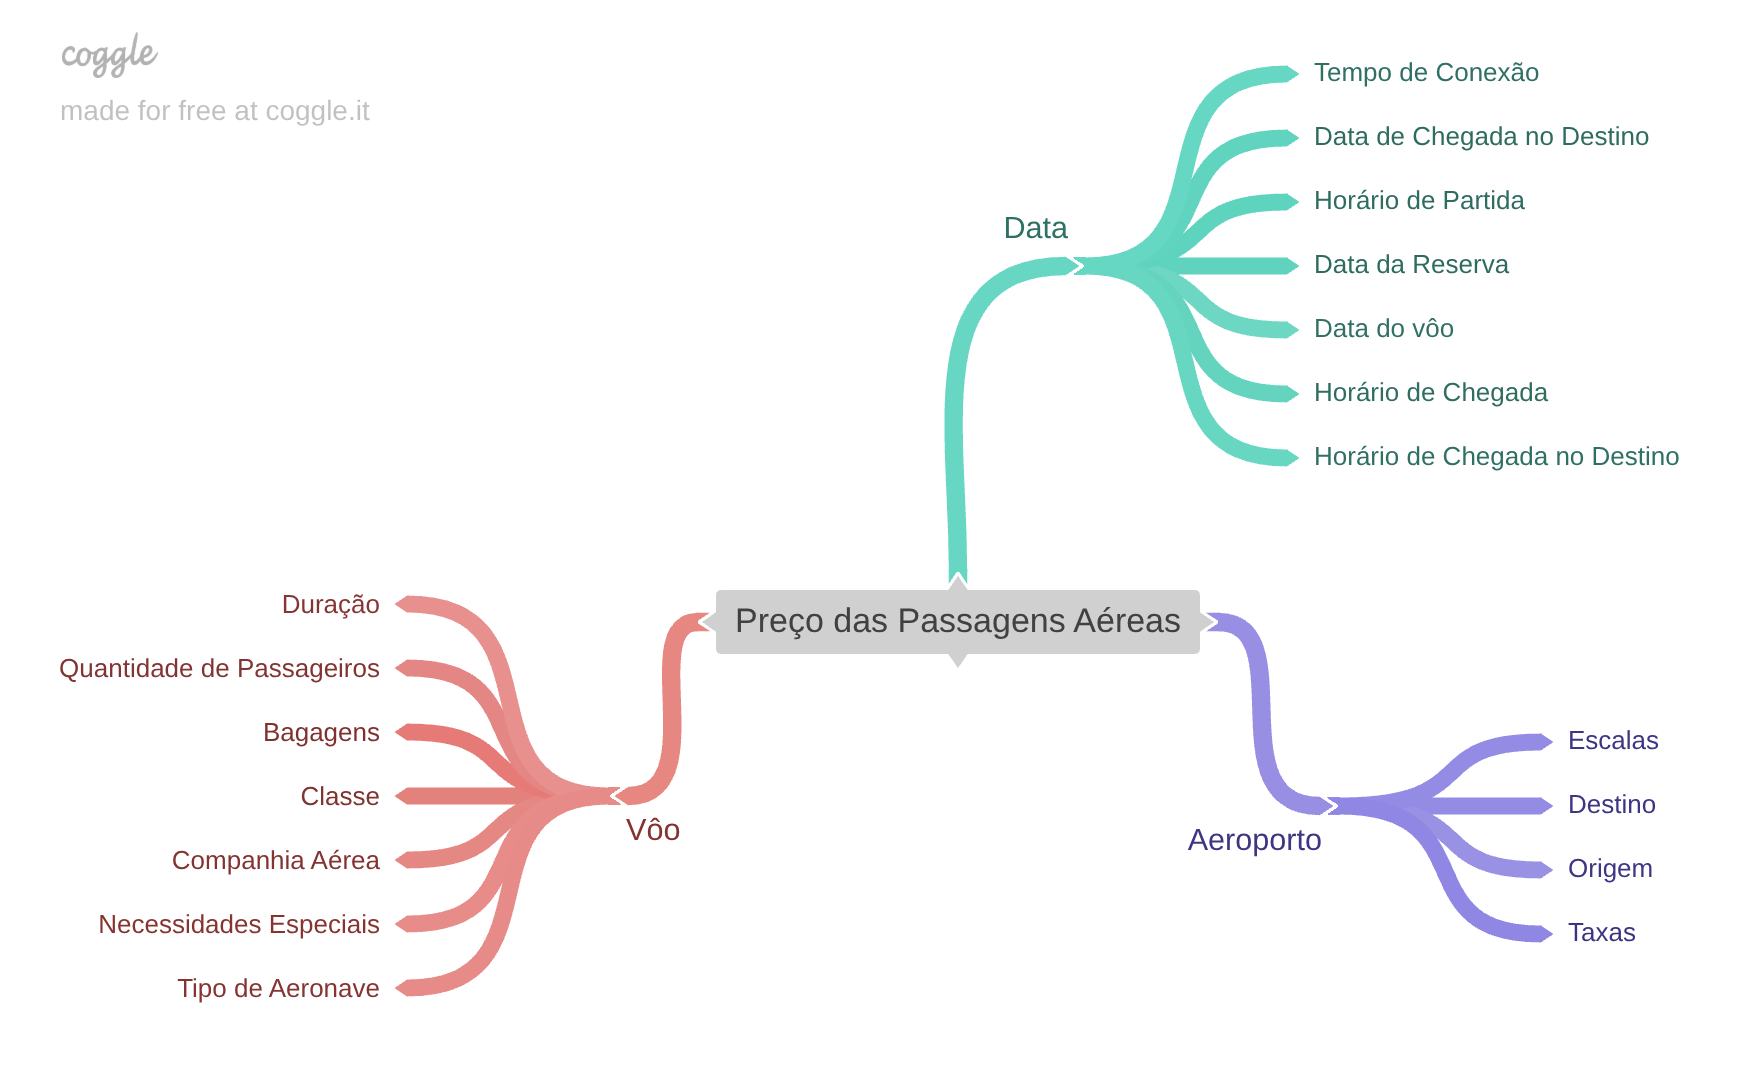

In [64]:
Image('data/mind_map_passagens.png')

CIDADES:

- Delhi – Capital nacional, abriga o governo central e é uma das maiores metrópoles do país.
- Mumbai – Capital financeira da Índia, sede da Bolsa de Valores e da indústria cinematográfica de Bollywood.
- Bangalore – Conhecida como o "Vale do Silício da Índia", é o principal polo de tecnologia e inovação.
- Kolkata – Antiga capital colonial britânica, é um centro cultural e intelectual no leste do país.
- Hyderabad – Outro grande polo de tecnologia, com forte presença de empresas de TI e farmacêuticas.
- Chennai – Importante cidade portuária no sul da Índia, com destaque na indústria automobilística e cinematográfica (Bollywood).
Se quiser, posso te mostrar essas cidades no mapa ou comparar dados como população, clima ou custo de vida!

### 2.2 Lista de Hipóteses

- Passagens com destino a Delhi e Mumbai são mais caras;
- Voos com mais conexões são mais caros;
- Quanto maior a antecedência da data da reserva em relação à data da viagem, mais barata é a passagem;
- A classe da passagens influencia o preço;
- Voos mais longos são mais caros;
- A cia aerea influencia no preço da passagem

### 2.3 Feature Engineering

In [117]:
#year
df2['year'] = df2['data_voo'].dt.year

#month
df2['month'] = df2['data_voo'].dt.month

#day
df2['day'] = df2['data_voo'].dt.day

#week of year
df2['week_of_year'] = df2['data_voo'].dt.isocalendar().week

#year week
df2['year_week'] = df2['data_voo'].dt.strftime('%Y-%W')

#dia da semana
df2['day_of_week'] = df2.data_voo.dt.day_of_week.astype(int)

#fim de semana
df2['is_weekend'] = np.where(df2['day_of_week'].isin([5,6]),1,0)

### 2.4 Filtragem das Variáveis

In [118]:
df2.head()

,desconhecido,data_voo,cia_aerea,cidade_origem,escalas,cidade_destino,preco,dias_restantes,cd_voo,duracao_horas,periodo_partida,periodo_chegada,year,month,day,week_of_year,year_week,day_of_week,is_weekend
0,0,2022-02-11,SpiceJet,Delhi,0,Mumbai,5953,1,SG8709,2.17,noite,noite,2022,2,11,6,2022-06,4,0
1,1,2022-02-11,SpiceJet,Delhi,0,Mumbai,5953,1,SG8157,2.33,manhã,manhã,2022,2,11,6,2022-06,4,0
2,2,2022-02-11,AirAsia,Delhi,0,Mumbai,5956,1,I5764,2.17,madrugada,manhã,2022,2,11,6,2022-06,4,0
3,3,2022-02-11,Vistara,Delhi,0,Mumbai,5955,1,UK995,2.25,manhã,tarde,2022,2,11,6,2022-06,4,0
4,4,2022-02-11,Vistara,Delhi,0,Mumbai,5955,1,UK963,2.33,manhã,manhã,2022,2,11,6,2022-06,4,0


In [119]:
df2['year'].unique()

array([2022], dtype=int32)

In [120]:
df2.drop(columns = ['year', 'data_voo'], inplace = True)

In [121]:
df2.columns

Index(['desconhecido', 'cia_aerea', 'cidade_origem', 'escalas',
       'cidade_destino', 'preco', 'dias_restantes', 'cd_voo', 'duracao_horas',
       'periodo_partida', 'periodo_chegada', 'month', 'day', 'week_of_year',
       'year_week', 'day_of_week', 'is_weekend'],
      dtype='object')

## 3.0 Análise Exploratória dos Dados

In [122]:
df3 = df2.copy()

### 3.1 Análise Univariada

#### 3.1.1 Variável Resposta

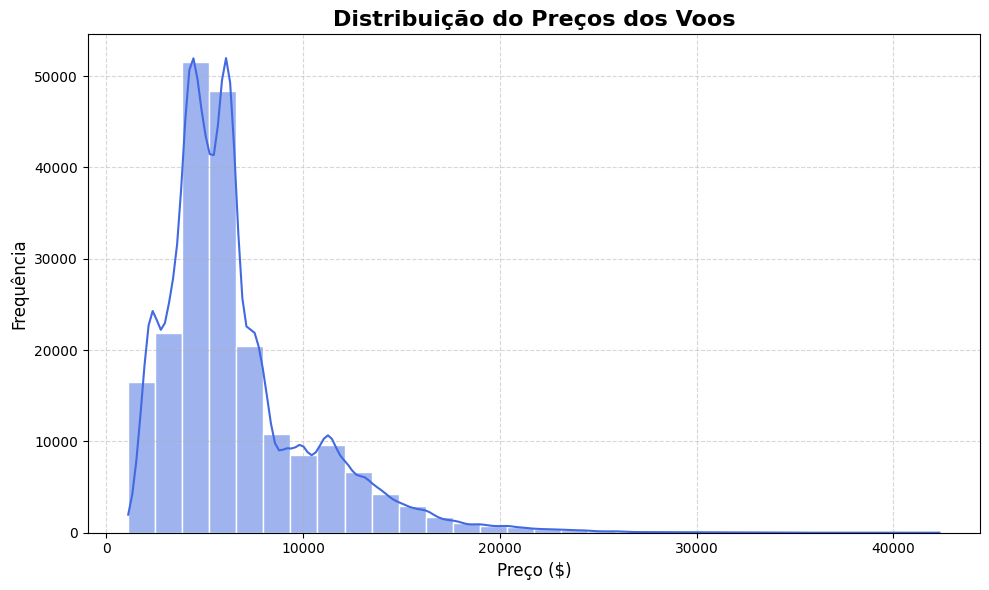

In [123]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df3,
    x='preco',
    kde=True,
    bins=30,
    color='royalblue',
    edgecolor='white'
)

plt.title('Distribuição do Preços dos Voos', fontsize=16, fontweight='bold')
plt.xlabel('Preço ($)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 3.1.2 Variáveis Numéricas

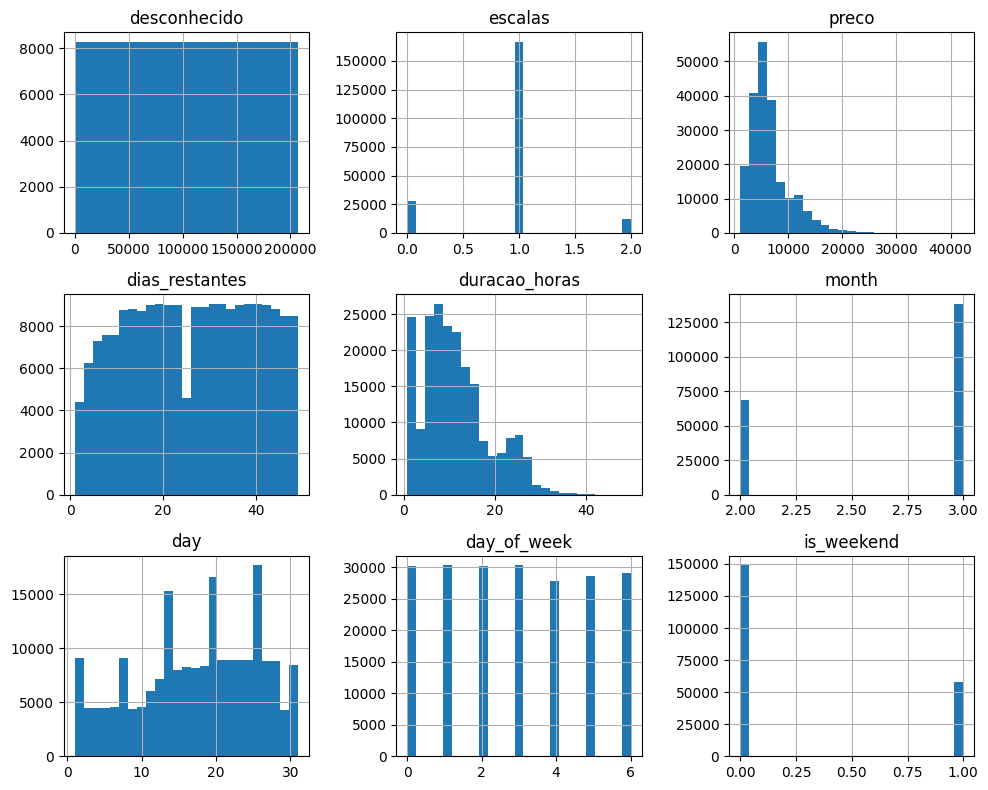

In [124]:
num_attributes = df3.select_dtypes(include = ['int64', 'int32', 'float64'])
num_attributes.hist(bins=25, figsize=(10, 8))
plt.tight_layout()
plt.show()

#### 3.1.3 Variáveis Categóricas

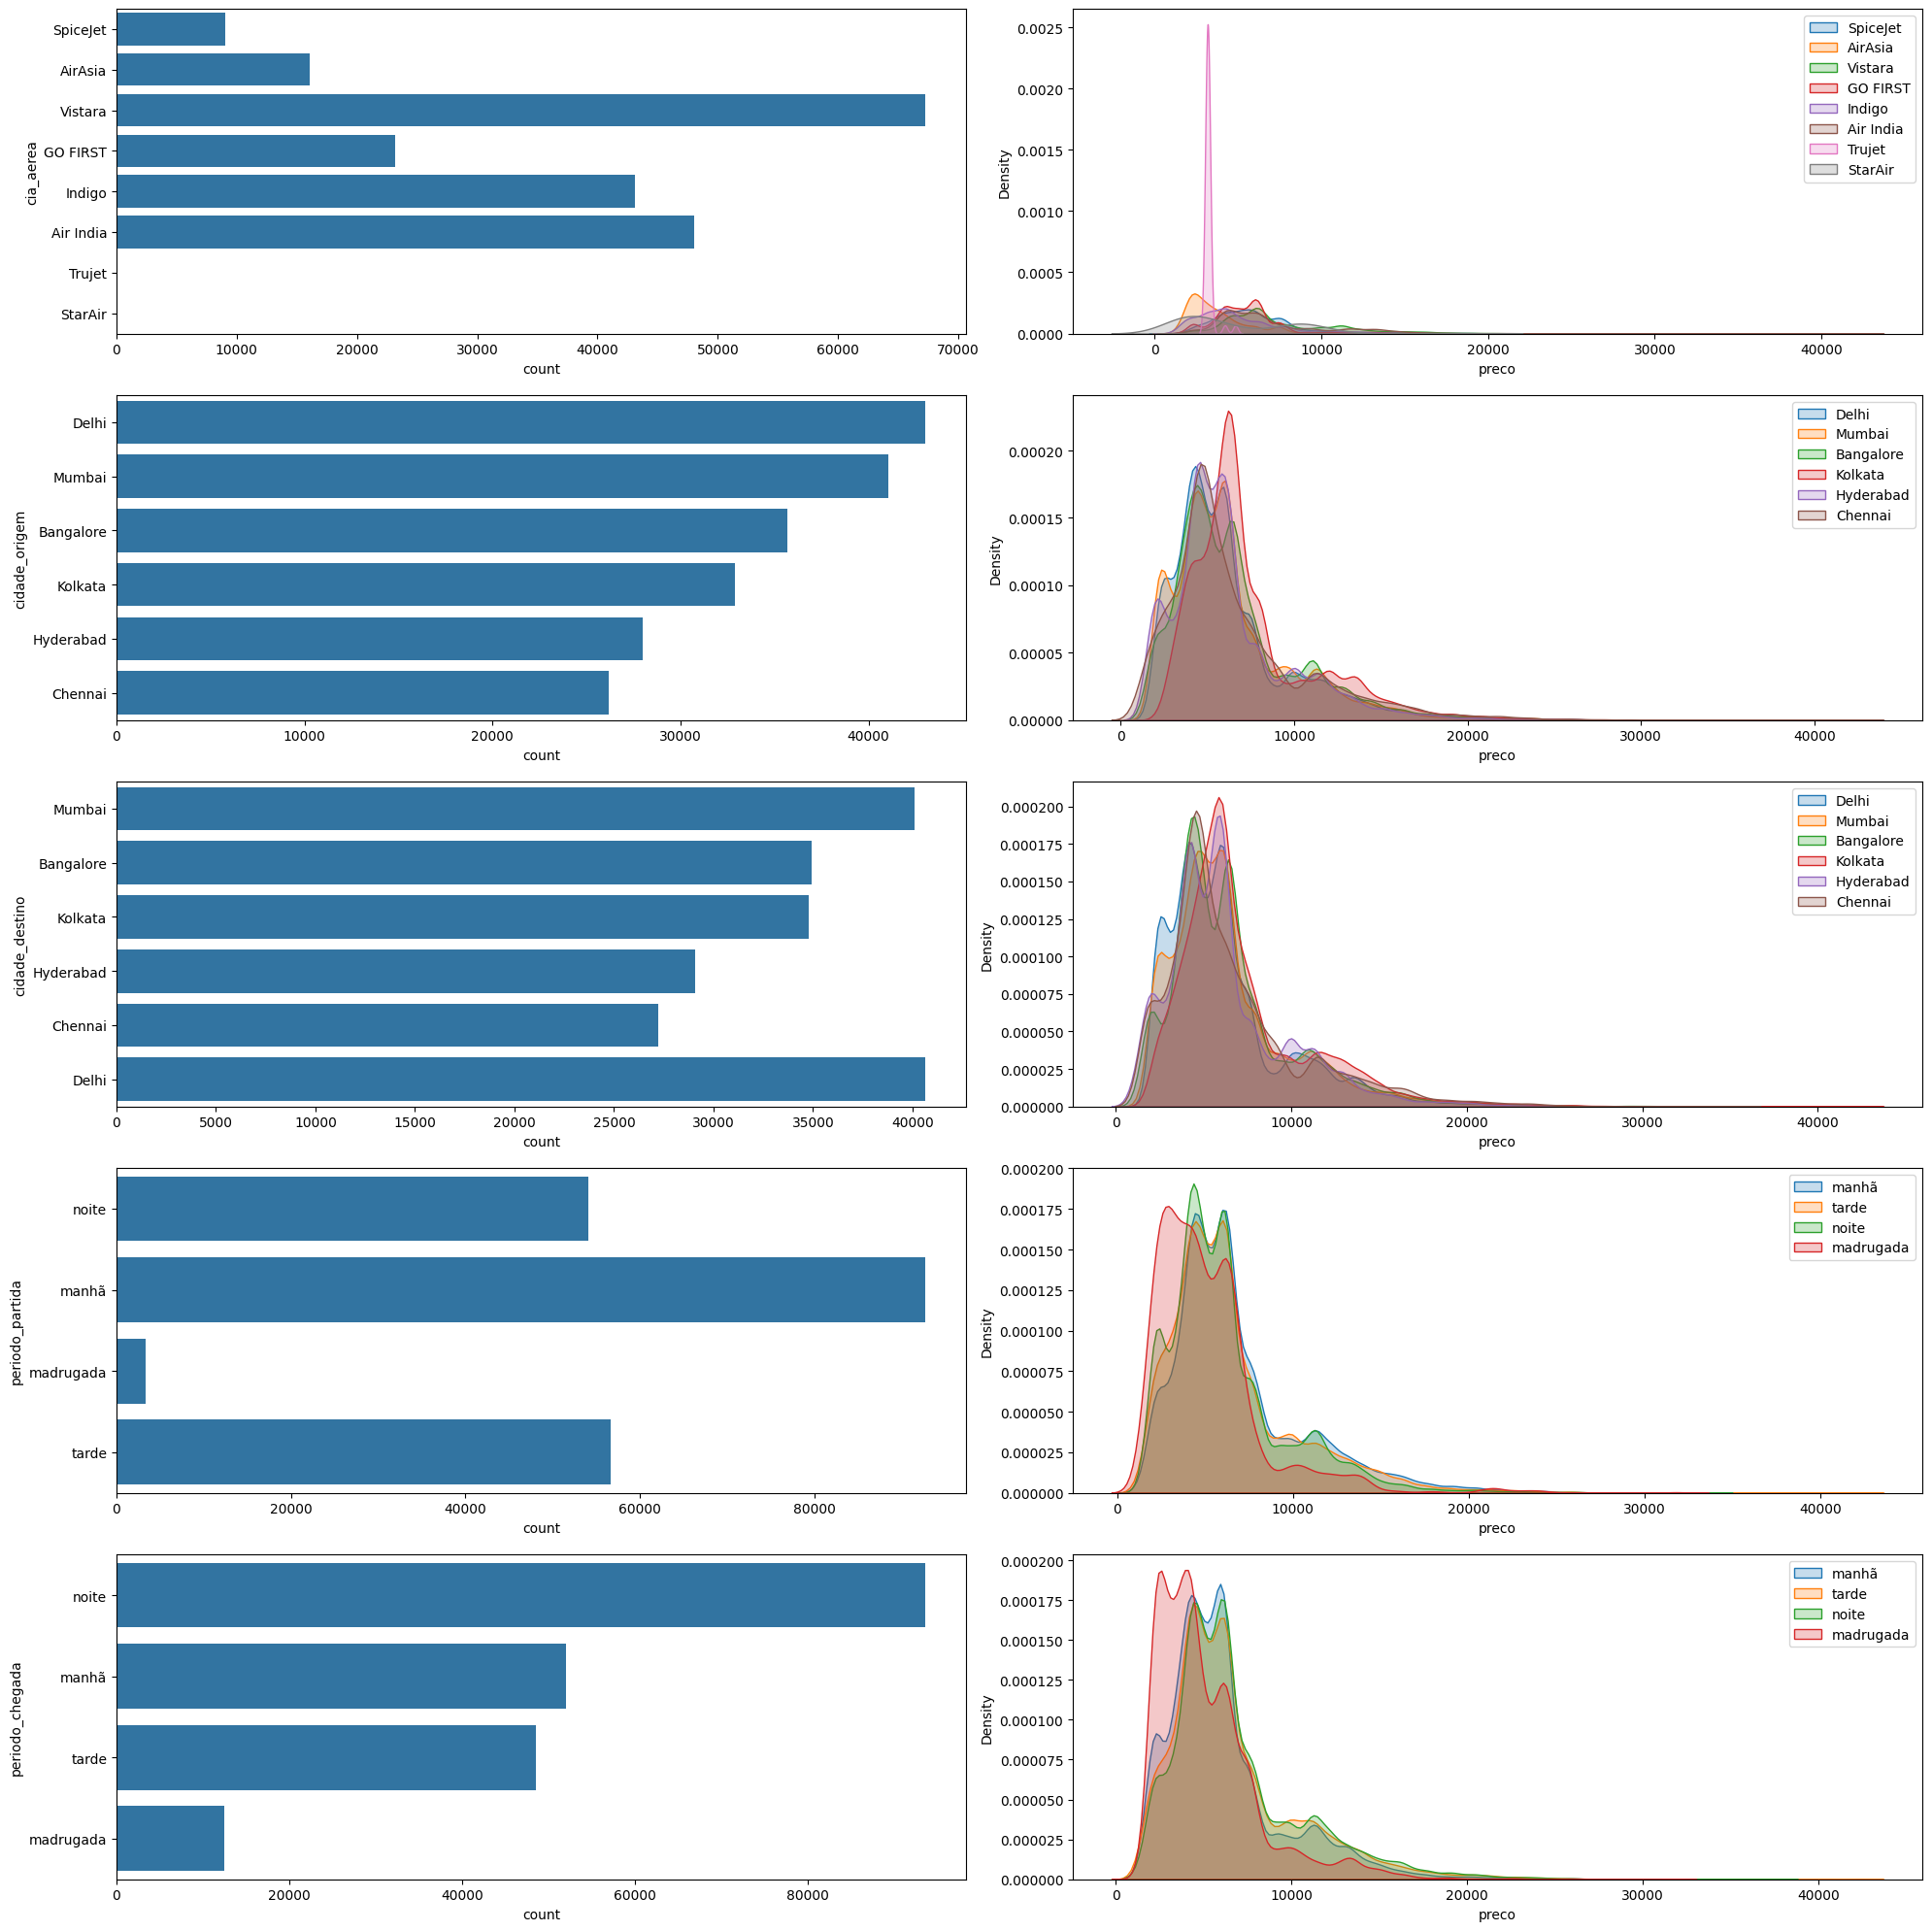

In [128]:
#cia aerea

plt.figure(figsize=[20,20])
plt.subplot(5,2,1)
sns.countplot(df3['cia_aerea'])

plt.subplot(5,2,2)
sns.kdeplot(df3[df3['cia_aerea'] == 'SpiceJet']['preco'], label = 'SpiceJet', fill = True)
sns.kdeplot(df3[df3['cia_aerea'] == 'AirAsia']['preco'], label = 'AirAsia', fill = True)
sns.kdeplot(df3[df3['cia_aerea'] == 'Vistara']['preco'], label = 'Vistara', fill = True)
sns.kdeplot(df3[df3['cia_aerea'] == 'GO FIRST']['preco'], label = 'GO FIRST', fill = True)
sns.kdeplot(df3[df3['cia_aerea'] == 'Indigo']['preco'], label = 'Indigo', fill = True)
sns.kdeplot(df3[df3['cia_aerea'] == 'Air India']['preco'], label = 'Air India', fill = True)
sns.kdeplot(df3[df3['cia_aerea'] == 'Trujet']['preco'], label = 'Trujet', fill = True)
sns.kdeplot(df3[df3['cia_aerea'] == 'StarAir']['preco'], label = 'StarAir', fill = True)

plt.legend()

# 'cidade_origem'

plt.subplot(5,2,3)
sns.countplot(df3['cidade_origem'])

plt.subplot(5,2,4)
sns.kdeplot(df3[df3['cidade_origem'] == 'Delhi']['preco'], label = 'Delhi', fill = True)
sns.kdeplot(df3[df3['cidade_origem'] == 'Mumbai']['preco'], label = 'Mumbai', fill = True)
sns.kdeplot(df3[df3['cidade_origem'] == 'Bangalore']['preco'], label = 'Bangalore', fill = True)
sns.kdeplot(df3[df3['cidade_origem'] == 'Kolkata']['preco'], label = 'Kolkata', fill = True)
sns.kdeplot(df3[df3['cidade_origem'] == 'Hyderabad']['preco'], label = 'Hyderabad', fill = True)
sns.kdeplot(df3[df3['cidade_origem'] == 'Chennai']['preco'], label = 'Chennai', fill = True)

plt.legend()

#cidade destino

plt.subplot(5,2,5)
sns.countplot(df3['cidade_destino'])

plt.subplot(5,2,6)
sns.kdeplot(df3[df3['cidade_destino'] == 'Delhi']['preco'], label = 'Delhi', fill = True)
sns.kdeplot(df3[df3['cidade_destino'] == 'Mumbai']['preco'], label = 'Mumbai', fill = True)
sns.kdeplot(df3[df3['cidade_destino'] == 'Bangalore']['preco'], label = 'Bangalore', fill = True)
sns.kdeplot(df3[df3['cidade_destino'] == 'Kolkata']['preco'], label = 'Kolkata', fill = True)
sns.kdeplot(df3[df3['cidade_destino'] == 'Hyderabad']['preco'], label = 'Hyderabad', fill = True)
sns.kdeplot(df3[df3['cidade_destino'] == 'Chennai']['preco'], label = 'Chennai', fill = True)

plt.legend()

#periodo partida

plt.subplot(5,2,7)
sns.countplot(df3['periodo_partida'])

plt.subplot(5,2,8)
sns.kdeplot(df3[df3['periodo_partida'] == 'manhã']['preco'], label = 'manhã', fill = True)
sns.kdeplot(df3[df3['periodo_partida'] == 'tarde']['preco'], label = 'tarde', fill = True)
sns.kdeplot(df3[df3['periodo_partida'] == 'noite']['preco'], label = 'noite', fill = True)
sns.kdeplot(df3[df3['periodo_partida'] == 'madrugada']['preco'], label = 'madrugada', fill = True)

plt.legend()

#periodo chegada

plt.subplot(5,2,9)
sns.countplot(df3['periodo_chegada'])

plt.subplot(5,2,10)
sns.kdeplot(df3[df3['periodo_chegada'] == 'manhã']['preco'], label = 'manhã', fill = True)
sns.kdeplot(df3[df3['periodo_chegada'] == 'tarde']['preco'], label = 'tarde', fill = True)
sns.kdeplot(df3[df3['periodo_chegada'] == 'noite']['preco'], label = 'noite', fill = True)
sns.kdeplot(df3[df3['periodo_chegada'] == 'madrugada']['preco'], label = 'madrugada', fill = True)

plt.legend()

plt.tight_layout()
plt.show()

### 3.2 Análise Bivariada